## 多層パーセプトロン(MLP)による多ラベル（非排他）分類

In [1]:
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus.reader import *

# コーパスのロード
ma_reuters = LazyCorpusLoader(
    'ma_reuters', CategorizedPlaintextCorpusReader, '(training|test).*',
    cat_file='cats.txt', encoding='ISO-8859-2')

# MA_Reutersのロード
documents = ma_reuters.fileids()
print (str(len(documents)) + " 記事総数")
# 訓練とテストデータの文書IDの抽出
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))
print (str(len(train_docs_id)) + " 訓練データ")
print (str(len(test_docs_id)) + " テストデータ")
# 訓練とテストデータの生データの抽出
train_docs = [ma_reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [ma_reuters.raw(doc_id) for doc_id in test_docs_id]
 
# カテゴリーのリスト
categories = ma_reuters.categories()
num_categories = len(categories)
print (num_categories, " カテゴリー")
print (categories)

10700 記事総数
7713 訓練データ
2987 テストデータ
55  カテゴリー
['acq', 'alum', 'barley', 'bop', 'carcass', 'cocoa', 'coffee', 'copper', 'corn', 'cotton', 'cpi', 'crude', 'dlr', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'hog', 'housing', 'interest', 'ipi', 'iron-steel', 'jobs', 'lead', 'livestock', 'meal-feed', 'money-fx', 'money-supply', 'nat-gas', 'oilseed', 'orange', 'palm-oil', 'pet-chem', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


## TF-IDF重みによるベクトル化

In [12]:
from nltk import word_tokenize
import re
 
def tokenize(text): # テキストをトークンに変換してリストで返す関数
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))

    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter (lambda token: p.match(token) and len(token) >= min_length, words))
    return filtered_tokens

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF重みでベクトル化
vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
# 訓練データはfit_transform関数で決められた語彙に基づきTF-IDFを計算
vectorised_train_documents = vectorizer.fit_transform(train_docs)
# テストデータはtransform関数で決められた語彙に基づきTF-IDFを計算
vectorised_test_documents = vectorizer.transform(test_docs)
print("TF-IDFモデルに変換しました")
print("訓練データの文書数x次元数：",vectorised_train_documents.shape)
print("テストデータの文書数x次元数：",vectorised_test_documents.shape)

TF-IDFモデルに変換しました
訓練データの文書数x次元数： (7713, 26979)
テストデータの文書数x次元数： (2987, 26979)


## Kerasの設定

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Kerasの定義
import keras
from tensorflow.compat.v1.keras import backend as K
K.set_session(session) 

## NNのモデル作成

In [22]:
from keras.models import Model 
from keras.layers import Input, Dense, Dropout 
from keras.optimizers import RMSprop 
BoW_dimension = vectorised_train_documents.shape[1]
NUM_CLASSES = 55 # カテゴリー数

inputs = Input(shape=(BoW_dimension,)) # 入力データ1個はBoW次元が何個か
x = Dense(512, activation='elu')(inputs) # 第一全結合層の出力は512次元
x = Dropout(0.3)(x) # ドロップアウトは40%（過学習の回避）
x = Dense(512, activation='elu')(x) # 第一全結合層の出力は512次元
x = Dropout(0.3)(x) # ドロップアウトは40%（過学習の回避）
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x) # 最終層の出力は10値
model = Model(inputs=[inputs], outputs=[outputs]) # モデル生成

model.summary() # ニューラルネットのパラメータ概要表示

model.compile( # モデルのコンパイル
    loss='binary_crossentropy', # 多ラベルであるため、損失関数はバイナリクロスエントロピーが良い
    optimizer='adam', # 最適化関数はAdam
    metrics=['categorical_accuracy']) # 測定はcategorical_accuracy（正解率）

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 26979)]           0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               13813760  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 55)                28215     
Total params: 14,104,631
Trainable params: 14,104,631
Non-trainable params: 0
_________________________________________

## 学習

In [23]:
import scipy
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform([ma_reuters.categories(doc_id) for doc_id in train_docs_id])
test_labels = mlb.transform([ma_reuters.categories(doc_id) for doc_id in test_docs_id])

batch_size = 128 # バッチサイズ(128)
epochs = 40 # エポック(40)

fpath = 'mlp-weights.{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5'
callbacks = [
    keras.callbacks.ModelCheckpoint(fpath, monitor='val_loss', save_best_only=True),
]

sorted_vectorised_train_documents = vectorised_train_documents.sorted_indices()
sorted_vectorised_test_documents = vectorised_test_documents.sorted_indices()

history = model.fit( 
    x=sorted_vectorised_train_documents,
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    callbacks=callbacks,
    validation_data=(sorted_vectorised_test_documents, test_labels))

Epoch 1/40
61/61 [==============================] - 3s 43ms/step - loss: 0.1841 - categorical_accuracy: 0.3081 - val_loss: 0.0685 - val_categorical_accuracy: 0.3656
Epoch 2/40
61/61 [==============================] - 2s 40ms/step - loss: 0.0573 - categorical_accuracy: 0.5623 - val_loss: 0.0463 - val_categorical_accuracy: 0.6863
Epoch 3/40
61/61 [==============================] - 2s 38ms/step - loss: 0.0386 - categorical_accuracy: 0.7074 - val_loss: 0.0356 - val_categorical_accuracy: 0.7492
Epoch 4/40
61/61 [==============================] - 2s 39ms/step - loss: 0.0271 - categorical_accuracy: 0.7827 - val_loss: 0.0292 - val_categorical_accuracy: 0.7861
Epoch 5/40
61/61 [==============================] - 2s 40ms/step - loss: 0.0198 - categorical_accuracy: 0.8289 - val_loss: 0.0261 - val_categorical_accuracy: 0.8092
Epoch 6/40
61/61 [==============================] - 5s 80ms/step - loss: 0.0148 - categorical_accuracy: 0.8523 - val_loss: 0.0240 - val_categorical_accuracy: 0.8165
Epoch 7/40

# 学習結果の評価

## 訓練したモデルによる訓練データとテストデータの予測

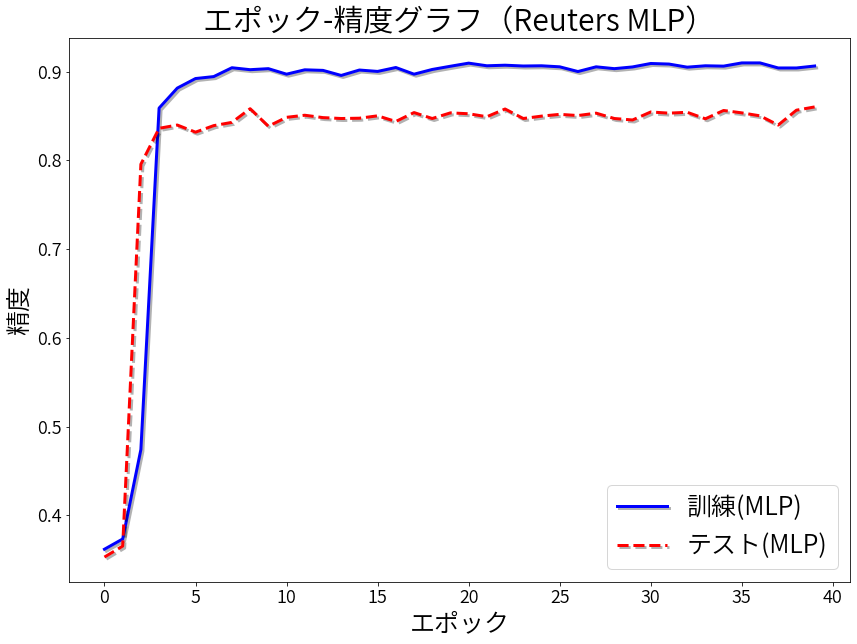

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

plt.figure(figsize=(14,10))

plt.plot(history.history['categorical_accuracy'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_categorical_accuracy'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=18)

plt.title('エポック-精度グラフ（Reuters MLP）',fontsize=30)
plt.ylabel('精度',fontsize=25)
plt.xlabel('エポック',fontsize=25)
plt.legend(['訓練(MLP)', 'テスト(MLP)'], loc='best', fontsize=25)

plt.show()

## SVMとの比較

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
# マルチクラス　マルチラベル分類器で訓練＋予測
OVR_classifier = OneVsRestClassifier(LinearSVC(random_state=41)) 
OVR_classifier.fit(vectorised_train_documents, train_labels)
train_predictions = OVR_classifier.predict(vectorised_train_documents)
test_predictions = OVR_classifier.predict(vectorised_test_documents)

print(f'SVMによる訓練データの予測精度：{accuracy_score(train_labels, train_predictions)}')
print(f'SVMによるテストデータの予測精度：{accuracy_score(test_labels, test_predictions)}')

SVMによる訓練データの予測精度：0.9782185919875535
SVMによるテストデータの予測精度：0.8205557415467024


## 結果
MLPのテストデータに対する精度(accuracy)は40エポックの学習後に86%となった。  
一方、SVMのテストデータに対する精度(accuracy)は82%であった。  
よって、今回の結果では、MLPによる予測の方が優れていた。